<a href="https://colab.research.google.com/github/Ahnaf-045/TugasPemrogramanKomputer/blob/main/Tugas_Minggu_12_Kelompok_10_C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rasterio geopandas gdown pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 81.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.sample import sample_gen
import numpy as np
from datetime import datetime
import os

def download_and_process_data():
    """
    Process geospatial data from GeoTIFF, GPKG, and CSV files.

    Note: Download the files from Google Drive first:
    1. GeoTIFF: https://drive.google.com/file/d/1-Zdq_ZXj4WoX5ubQnoHRjSlHfHrx07x0/view?usp=sharing
    2. GPKG: https://drive.google.com/file/d/1AQcHlqzmpQIukLyPIkUnb04-pbjoET_y/view?usp=sharing
    3. CSV: https://drive.google.com/file/d/1v8_2PwMxl1QGdcbC_RPgUGtYSZsmJDri/view?usp=sharing
    """

    # File paths (update these to match your downloaded files)
    geotiff_path = "your_geotiff_file.tif"  # Replace with actual filename
    gpkg_path = "your_survey_data.gpkg"     # Replace with actual filename
    csv_path = "perioda.csv"                # Replace with actual filename

    print("Starting geospatial data processing...")

    # Step 1: Load survey data from GPKG
    print("Loading survey data from GPKG...")
    try:
        survey_data = gpd.read_file(gpkg_path)
        print(f"Survey data loaded: {len(survey_data)} records")
        print("Columns:", survey_data.columns.tolist())
    except Exception as e:
        print(f"Error loading GPKG: {e}")
        return None

    # Step 2: Load period lookup table
    print("Loading period lookup table...")
    try:
        period_lookup = pd.read_csv(csv_path)
        print(f"Period lookup loaded: {len(period_lookup)} records")
        print("Columns:", period_lookup.columns.tolist())
    except Exception as e:
        print(f"Error loading CSV: {e}")
        return None

    # Step 3: Filter and prepare survey data
    print("Filtering survey data...")

    # Extract coordinates (assuming geometry column exists)
    if 'geometry' in survey_data.columns:
        survey_data['lon'] = survey_data.geometry.x
        survey_data['lat'] = survey_data.geometry.y

    # Create filtered table with required columns
    # Adjust column names based on your actual data structure
    required_cols = ['fid', 'lon', 'lat', 'date', 'fase']

    # Check which columns exist and map them
    available_cols = survey_data.columns.tolist()
    print(f"Available columns: {available_cols}")

    # Create mapping for common column name variations
    column_mapping = {}
    for col in required_cols:
        if col in available_cols:
            column_mapping[col] = col
        elif col.upper() in available_cols:
            column_mapping[col] = col.upper()
        elif col.lower() in available_cols:
            column_mapping[col] = col.lower()
        elif col == 'fid' and 'FID' in available_cols:
            column_mapping[col] = 'FID'
        elif col == 'fid' and 'id' in available_cols:
            column_mapping[col] = 'id'
        elif col == 'date' and 'Date' in available_cols:
            column_mapping[col] = 'Date'
        elif col == 'fase' and 'phase' in available_cols:
            column_mapping[col] = 'phase'

    # Filter data with existing columns
    filtered_data = survey_data.copy()

    # Rename columns to standard names
    for new_name, old_name in column_mapping.items():
        if old_name in filtered_data.columns:
            filtered_data = filtered_data.rename(columns={old_name: new_name})

    # Select only required columns that exist
    existing_cols = [col for col in required_cols if col in filtered_data.columns]
    filtered_survey = filtered_data[existing_cols + ['geometry'] if 'geometry' in filtered_data.columns else existing_cols].copy()

    print(f"Filtered survey data: {len(filtered_survey)} records")
    print("Table 1 - Filtered Survey Data:")
    print(filtered_survey.head())

    # Step 4: Add period information
    print("Adding period information...")

    # Merge with period lookup table
    # Adjust merge column based on your data structure
    if 'date' in filtered_survey.columns and len(period_lookup.columns) >= 2:
        # Assuming period lookup has date and period columns
        period_col_names = period_lookup.columns.tolist()

        # Convert date columns to datetime for proper matching
        if 'date' in filtered_survey.columns:
            try:
                filtered_survey['date'] = pd.to_datetime(filtered_survey['date'])
            except:
                pass

        # Merge based on the first column of period lookup (assuming it's the key)
        merge_key = period_col_names[0]
        period_key = period_col_names[1] if len(period_col_names) > 1 else 'periode'

        try:
            # Try different merge strategies
            if merge_key in filtered_survey.columns:
                survey_with_period = filtered_survey.merge(
                    period_lookup,
                    left_on=merge_key,
                    right_on=period_col_names[0],
                    how='left'
                )
            else:
                # Create a simple period assignment based on date ranges or other logic
                survey_with_period = filtered_survey.copy()
                survey_with_period['periode'] = 1  # Default period

        except Exception as e:
            print(f"Merge error: {e}")
            survey_with_period = filtered_survey.copy()
            survey_with_period['periode'] = 1  # Default period
    else:
        survey_with_period = filtered_survey.copy()
        survey_with_period['periode'] = 1  # Default period

    print("Table 2 - Survey Data with Period:")
    print(survey_with_period.head())

    # Step 5: Extract raster values
    print("Extracting raster values...")

    try:
        with rasterio.open(geotiff_path) as src:
            print(f"Raster info: {src.count} bands, {src.width}x{src.height} pixels")

            # Prepare coordinates for sampling
            coords = [(lon, lat) for lon, lat in zip(survey_with_period['lon'], survey_with_period['lat'])]

            # Extract values for each point and each period
            final_results = []

            for idx, row in survey_with_period.iterrows():
                try:
                    coord = (row['lon'], row['lat'])
                    periode = int(row.get('periode', 1))

                    # Ensure period is within valid band range
                    if periode > src.count:
                        periode = 1

                    # Sample the raster at the point location for the specific band
                    sampled_values = list(sample_gen(src, [coord], indexes=[periode]))
                    p0_value = sampled_values[0][0] if sampled_values and len(sampled_values[0]) > 0 else np.nan

                    # Create result row
                    result_row = {
                        'fid': row.get('fid', idx),
                        'lon': row['lon'],
                        'lat': row['lat'],
                        'date': row.get('date', ''),
                        'fase': row.get('fase', ''),
                        'periode': periode,
                        'p0': p0_value
                    }

                    final_results.append(result_row)

                except Exception as e:
                    print(f"Error processing point {idx}: {e}")
                    continue

            # Create final DataFrame
            final_df = pd.DataFrame(final_results)

            print("Table 3 - Final Results with Raster Values:")
            print(final_df.head())
            print(f"\nFinal dataset: {len(final_df)} records")

            # Save results
            output_file = "processed_survey_data.csv"
            final_df.to_csv(output_file, index=False)
            print(f"Results saved to: {output_file}")

            return final_df

    except Exception as e:
        print(f"Error processing raster: {e}")
        return survey_with_period

def main():
    """
    Main function to run the data processing pipeline.
    """
    print("=== Geospatial Data Processing Pipeline ===")
    print()
    print("Before running this script, please:")
    print("1. Download the GeoTIFF file from Google Drive")
    print("2. Download the GPKG survey data file from Google Drive")
    print("3. Download the perioda.csv file from Google Drive")
    print("4. Update the file paths in the script")
    print()

    # Check if files exist
    files_to_check = ["your_geotiff_file.tif", "your_survey_data.gpkg", "perioda.csv"]
    missing_files = [f for f in files_to_check if not os.path.exists(f)]

    if missing_files:
        print("Missing files:")
        for f in missing_files:
            print(f"  - {f}")
        print("\nPlease download and update file paths before running.")
        return

    # Process the data
    result = download_and_process_data()

    if result is not None:
        print("\n=== Processing Complete ===")
        print("Three tables have been generated:")
        print("1. Filtered survey data (fid, lon, lat, date, fase)")
        print("2. Survey data with period (fid, lon, lat, date, fase, periode)")
        print("3. Final data with raster values (fid, lon, lat, date, fase, periode, p0)")
    else:
        print("Processing failed. Please check file paths and data format.")

if __name__ == "__main__":
    main()


# Alternative function for manual file processing
def process_with_custom_paths(geotiff_path, gpkg_path, csv_path):
    """
    Process data with custom file paths.

    Args:
        geotiff_path (str): Path to GeoTIFF file
        gpkg_path (str): Path to GPKG file
        csv_path (str): Path to CSV file
    """
    # Update the file paths in the global scope
    globals()['geotiff_path'] = geotiff_path
    globals()['gpkg_path'] = gpkg_path
    globals()['csv_path'] = csv_path

    return download_and_process_data()

=== Geospatial Data Processing Pipeline ===

Before running this script, please:
1. Download the GeoTIFF file from Google Drive
2. Download the GPKG survey data file from Google Drive
3. Download the perioda.csv file from Google Drive
4. Update the file paths in the script

Missing files:
  - your_geotiff_file.tif
  - your_survey_data.gpkg
  - perioda.csv

Please download and update file paths before running.


In [ ]:
try:
    import gdown
    import pandas as pd
    import geopandas as gpd
    import rasterio
    from rasterio.sample import sample_gen
    import numpy as np
    from datetime import datetime
    import os
except ImportError as e:
    print(f"Error: {e}")
    print("Please install missing packages using:")
    print("!pip install rasterio geopandas gdown pandas numpy")
    raise

# Rest of your code...
def download_and_process_data():
    """
    Download and process geospatial data from Google Drive links.
    """
    # Google Drive URLs and output files
    geotiff_url = "https://drive.google.com/uc?id=1-Zdq_ZXj4WoX5ubQnoHRjSlHfHrx07x0"
    gpkg_url = "https://drive.google.com/uc?id=1AQcHlqzmpQIukLyPIkUnb04-pbjoET_y"
    csv_url = "https://drive.google.com/uc?id=1v8_2PwMxl1QGdcbC_RPgUGtYSZsmJDri"

    geotiff_path = "downloaded_geotiff.tif"
    gpkg_path = "downloaded_survey.gpkg"
    csv_path = "perioda.csv"

    print("Starting download and processing...")

    # Download files using gdown
    try:
        print("Downloading GeoTIFF...")
        gdown.download(geotiff_url, geotiff_path, quiet=False)

        print("Downloading GPKG...")
        gdown.download(gpkg_url, gpkg_path, quiet=False)

        print("Downloading CSV...")
        gdown.download(csv_url, csv_path, quiet=False)

        print("All files downloaded successfully!")
    except Exception as e:
        print(f"Download error: {e}")
        return None

    # Step 1: Load and prepare survey data
    print("\nLoading survey data from GPKG...")
    try:
        survey_data = gpd.read_file(gpkg_path).to_crs(epsg=4326)
        survey_data["lon"] = survey_data.geometry.x
        survey_data["lat"] = survey_data.geometry.y
        survey_data["fid"] = survey_data.index.astype(int)

        # Handle column name variations
        if "tanggal" in survey_data.columns:
            survey_data = survey_data.rename(columns={"tanggal": "date"})
        if "Phase" in survey_data.columns:
            survey_data = survey_data.rename(columns={"Phase": "fase"})

        # Select required columns
        required_cols = ['fid', 'lon', 'lat', 'date', 'fase']
        missing_cols = [c for c in required_cols if c not in survey_data.columns]

        if missing_cols:
            print(f"Warning: Missing columns: {missing_cols}. Adding with default values.")
            for col in missing_cols:
                if col == 'date':
                    survey_data[col] = datetime.now().strftime('%Y-%m-%d')
                elif col == 'fase':
                    survey_data[col] = 'unknown'

        output1 = survey_data[required_cols].copy()
        print("\n✅ TABEL 1 - Filtered survey data")
        print(output1.head())
    except Exception as e:
        print(f"Error loading GPKG: {e}")
        return None

    # Step 2: Load and merge period data
    print("\nLoading period lookup table...")
    try:
        period_lookup = pd.read_csv(csv_path, sep=';')
        period_lookup = period_lookup.rename(columns={"Periode": "fase"})
        period_lookup['fase'] = period_lookup['fase'].astype(str).str.strip()
        output1['fase'] = output1['fase'].astype(str).str.strip()

        output2 = pd.merge(output1, period_lookup, on="fase", how="left")

        # Convert fase to integer for band selection
        try:
            output2["periode"] = output2["fase"].astype(int)
        except ValueError:
            print("Warning: Could not convert 'fase' to integer. Using default period 1.")
            output2["periode"] = 1

        print("\n✅ TABEL 2 - Survey data with period")
        print(output2.head())
    except Exception as e:
        print(f"Error loading/merging CSV: {e}")
        return None

    # Step 3: Extract raster values
    print("\nExtracting raster values...")
    try:
        with rasterio.open(geotiff_path) as src:
            print(f"Raster info: {src.count} bands, {src.width}x{src.height} pixels")

            def get_pixel_value(lon, lat, band):
                try:
                    if not 1 <= band <= src.count:
                        return None
                    for val in sample_gen(src, [(lon, lat)], indexes=[band]):
                        return val[0]
                except Exception as e:
                    print(f"Error at ({lon}, {lat}) band {band}: {e}")
                    return None

            output2["p0"] = output2.apply(
                lambda row: get_pixel_value(row["lon"], row["lat"], row["periode"]),
                axis=1
            )

            output3 = output2[['fid', 'lon', 'lat', 'date', 'fase', 'periode', 'p0']]
            print("\n✅ TABEL 3 - Final results with raster values")
            print(output3.head())

            # Save results
            output_file = "processed_survey_data.csv"
            output3.to_csv(output_file, index=False)
            print(f"\nResults saved to: {output_file}")

            # Clean up
            for file in [geotiff_path, gpkg_path, csv_path]:
                try:
                    if os.path.exists(file):
                        os.remove(file)
                except:
                    pass

            return output3

    except Exception as e:
        print(f"Error processing raster: {e}")
        return None

def main():
    print("=== Geospatial Data Processing Pipeline ===")
    result = download_and_process_data()

    if result is not None:
        print("\n=== Processing Complete ===")
        print("Tiga tabel telah berhasil dibuat:")
        print("1. TABEL 1: Data survey terfilter")
        print("2. TABEL 2: Data survey dengan periode")
        print("3. TABEL 3: Data final dengan nilai raster")
    else:
        print("Processing failed. Please check the error messages.")

if __name__ == "__main__":
    main()

=== Geospatial Data Processing Pipeline ===
Starting download and processing...


Downloading...
From (original): https://drive.google.com/uc?id=1-Zdq_ZXj4WoX5ubQnoHRjSlHfHrx07x0
From (redirected): https://drive.google.com/uc?id=1-Zdq_ZXj4WoX5ubQnoHRjSlHfHrx07x0&confirm=t&uuid=c03743cb-dcc8-4625-b948-75ce51b19698
To: /content/downloaded_geotiff.tif
100%|██████████| 1.92G/1.92G [00:11<00:00, 166MB/s]


Downloading...
From: https://drive.google.com/uc?id=1AQcHlqzmpQIukLyPIkUnb04-pbjoET_y
To: /content/downloaded_survey.gpkg
100%|██████████| 1.62M/1.62M [00:00<00:00, 117MB/s]


Downloading...
From: https://drive.google.com/uc?id=1v8_2PwMxl1QGdcbC_RPgUGtYSZsmJDri
To: /content/perioda.csv
100%|██████████| 827/827 [00:00<00:00, 1.42MB/s]


All files downloaded successfully!

Loading survey data from GPKG...

✅ TABEL 1 - Filtered survey data
   fid         lon       lat       date  fase
0    0  107.463959 -6.260439  3/18/2024     1
1    1  107.464081 -6.260284  3/18/2024     1
2    2  107.463608 -6.260762  3/18/2024     1
3    3  107.461742 -6.261511  3/18/2024     1
4    4  107.463209 -6.260423  3/18/2024     1

Loading period lookup table...

✅ TABEL 2 - Survey data with period
   fid         lon       lat       date fase  Start Date    End Date  periode
0    0  107.463959 -6.260439  3/18/2024    1  2024-01-01  2024-01-13        1
1    1  107.464081 -6.260284  3/18/2024    1  2024-01-01  2024-01-13        1
2    2  107.463608 -6.260762  3/18/2024    1  2024-01-01  2024-01-13        1
3    3  107.461742 -6.261511  3/18/2024    1  2024-01-01  2024-01-13        1
4    4  107.463209 -6.260423  3/18/2024    1  2024-01-01  2024-01-13        1

Extracting raster values...
Raster info: 31 bands, 8079x3834 pixels

✅ TABEL 3 - Fi

In [ ]:
!pip install rasterio geopandas gdown pandas

In [ ]:
try:
    import gdown
    import pandas as pd
    import geopandas as gpd
    import rasterio
    from rasterio.sample import sample_gen
    import numpy as np
    from datetime import datetime
    import os
except ImportError as e:
    print(f"Error: {e}")
    print("Please install missing packages using:")
    print("!pip install rasterio geopandas gdown pandas numpy")
    raise

def download_and_process_data():
    """
    Download and process geospatial data from Google Drive links.
    Creates a table with p0 (current period) and p1-p6 (previous periods).
    """
    # Google Drive URLs and output files
    geotiff_url = "https://drive.google.com/uc?id=1-Zdq_ZXj4WoX5ubQnoHRjSlHfHrx07x0"
    gpkg_url = "https://drive.google.com/uc?id=1AQcHlqzmpQIukLyPIkUnb04-pbjoET_y"
    csv_url = "https://drive.google.com/uc?id=1v8_2PwMxl1QGdcbC_RPgUGtYSZsmJDri"

    geotiff_path = "downloaded_geotiff.tif"
    gpkg_path = "downloaded_survey.gpkg"
    csv_path = "perioda.csv"

    print("Starting download and processing...")

    # Download files using gdown
    try:
        print("Downloading GeoTIFF...")
        gdown.download(geotiff_url, geotiff_path, quiet=False)

        print("Downloading GPKG...")
        gdown.download(gpkg_url, gpkg_path, quiet=False)

        print("Downloading CSV...")
        gdown.download(csv_url, csv_path, quiet=False)

        print("All files downloaded successfully!")
    except Exception as e:
        print(f"Download error: {e}")
        return None

    # Step 1: Load and prepare survey data
    print("\nLoading survey data from GPKG...")
    try:
        survey_data = gpd.read_file(gpkg_path).to_crs(epsg=4326)
        survey_data["lon"] = survey_data.geometry.x
        survey_data["lat"] = survey_data.geometry.y
        survey_data["fid"] = survey_data.index.astype(int)

        # Handle column name variations
        if "tanggal" in survey_data.columns:
            survey_data = survey_data.rename(columns={"tanggal": "date"})
        if "Phase" in survey_data.columns:
            survey_data = survey_data.rename(columns={"Phase": "fase"})

        # Select required columns
        required_cols = ['fid', 'lon', 'lat', 'date', 'fase']
        missing_cols = [c for c in required_cols if c not in survey_data.columns]

        if missing_cols:
            print(f"Warning: Missing columns: {missing_cols}. Adding with default values.")
            for col in missing_cols:
                if col == 'date':
                    survey_data[col] = datetime.now().strftime('%Y-%m-%d')
                elif col == 'fase':
                    survey_data[col] = 'unknown'

        output1 = survey_data[required_cols].copy()
        print("\n✅ TABEL 1 - Filtered survey data")
        print(output1.head())
    except Exception as e:
        print(f"Error loading GPKG: {e}")
        return None

    # Step 2: Load and merge period data
    print("\nLoading period lookup table...")
    try:
        period_lookup = pd.read_csv(csv_path, sep=';')
        period_lookup = period_lookup.rename(columns={"Periode": "fase"})
        period_lookup['fase'] = period_lookup['fase'].astype(str).str.strip()
        output1['fase'] = output1['fase'].astype(str).str.strip()

        output2 = pd.merge(output1, period_lookup, on="fase", how="left")

        # Convert fase to integer for band selection
        try:
            output2["periode"] = output2["fase"].astype(int)
        except ValueError:
            print("Warning: Could not convert 'fase' to integer. Using default period 1.")
            output2["periode"] = 1

        print("\n✅ TABEL 2 - Survey data with period")
        print(output2.head())
    except Exception as e:
        print(f"Error loading/merging CSV: {e}")
        return None

    # Step 3: Extract raster values for current and previous periods
    print("\nExtracting raster values for all periods...")
    try:
        with rasterio.open(geotiff_path) as src:
            print(f"Raster info: {src.count} bands, {src.width}x{src.height} pixels")

            def get_pixel_value(lon, lat, band):
                """Extract pixel value from specific band at given coordinates"""
                try:
                    if not 1 <= band <= src.count:
                        return None
                    for val in sample_gen(src, [(lon, lat)], indexes=[band]):
                        return val[0]
                except Exception as e:
                    print(f"Error at ({lon}, {lat}) band {band}: {e}")
                    return None

            # Extract values for current period (p0)
            print("Extracting current period values (p0)...")
            output2["p0"] = output2.apply(
                lambda row: get_pixel_value(row["lon"], row["lat"], row["periode"]),
                axis=1
            )

            # Extract values for previous periods (p1 to p6)
            print("Extracting previous period values (p1-p6)...")
            for i in range(1, 7):  # p1 to p6
                col_name = f"p{i}"
                print(f"  Processing {col_name}...")

                output2[col_name] = output2.apply(
                    lambda row: get_pixel_value(
                        row["lon"],
                        row["lat"],
                        max(1, row["periode"] - i)  # Ensure band >= 1
                    ) if row["periode"] - i >= 1 else None,
                    axis=1
                )

            # Create final output with all required columns
            final_cols = ['fid', 'lon', 'lat', 'date', 'fase', 'periode', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6']
            output3 = output2[final_cols].copy()

            print("\n✅ TABEL 3 - Final results with all period values")
            print(output3.head())
            print(f"\nSummary of extracted values:")
            for col in ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6']:
                non_null_count = output3[col].notna().sum()
                total_count = len(output3)
                print(f"  {col}: {non_null_count}/{total_count} valid values")

            # Save results
            output_file = "processed_survey_data_with_periods.csv"
            output3.to_csv(output_file, index=False)
            print(f"\nResults saved to: {output_file}")

            # Show example of period relationships
            print("\n📊 Example of period relationships:")
            if len(output3) > 0:
                sample_row = output3.iloc[0]
                current_period = sample_row['periode']
                print(f"Current periode: {current_period}")
                print(f"p0 (periode {current_period}): {sample_row['p0']}")
                for i in range(1, 7):
                    prev_period = max(1, current_period - i)
                    print(f"p{i} (periode {prev_period}): {sample_row[f'p{i}']}")

            # Clean up downloaded files
            for file in [geotiff_path, gpkg_path, csv_path]:
                try:
                    if os.path.exists(file):
                        os.remove(file)
                        print(f"Cleaned up: {file}")
                except:
                    pass

            return output3

    except Exception as e:
        print(f"Error processing raster: {e}")
        return None

def validate_results(df):
    """Validate the processing results"""
    if df is None or len(df) == 0:
        print("❌ No data to validate")
        return False

    print("\n🔍 Data Validation:")
    print(f"Total rows: {len(df)}")
    print(f"Total columns: {len(df.columns)}")

    # Check for required columns
    required_cols = ['lon', 'lat', 'date', 'fase', 'periode', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6']
    missing_cols = [col for col in required_cols if col not in df.columns]

    if missing_cols:
        print(f"❌ Missing columns: {missing_cols}")
        return False
    else:
        print("✅ All required columns present")

    # Check data completeness
    print("\nData completeness:")
    for col in ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6']:
        completeness = (df[col].notna().sum() / len(df)) * 100
        print(f"  {col}: {completeness:.1f}%")

    return True

def main():
    print("=== Enhanced Geospatial Data Processing Pipeline ===")
    print("This pipeline extracts backscatter values for current and previous periods")
    print("p0 = current period, p1-p6 = 1-6 periods before\n")

    result = download_and_process_data()

    if result is not None:
        print("\n=== Processing Complete ===")
        print("Tiga tabel telah berhasil dibuat:")
        print("1. TABEL 1: Data survey terfilter")
        print("2. TABEL 2: Data survey dengan periode")
        print("3. TABEL 3: Data final dengan nilai raster untuk semua periode")

        # Validate results
        validate_results(result)

        print(f"\n📈 Final dataset shape: {result.shape}")
        print("Columns:", list(result.columns))

    else:
        print("❌ Processing failed. Please check the error messages.")

if __name__ == "__main__":
    main()

=== Enhanced Geospatial Data Processing Pipeline ===
This pipeline extracts backscatter values for current and previous periods
p0 = current period, p1-p6 = 1-6 periods before

Starting download and processing...


Downloading...
From (original): https://drive.google.com/uc?id=1-Zdq_ZXj4WoX5ubQnoHRjSlHfHrx07x0
From (redirected): https://drive.google.com/uc?id=1-Zdq_ZXj4WoX5ubQnoHRjSlHfHrx07x0&confirm=t&uuid=4a6bbf6b-59a3-4072-9d86-2540b4f5b1f3
To: /content/downloaded_geotiff.tif
100%|██████████| 1.92G/1.92G [00:18<00:00, 105MB/s]


Downloading...
From: https://drive.google.com/uc?id=1AQcHlqzmpQIukLyPIkUnb04-pbjoET_y
To: /content/downloaded_survey.gpkg
100%|██████████| 1.62M/1.62M [00:00<00:00, 152MB/s]


Downloading...
From: https://drive.google.com/uc?id=1v8_2PwMxl1QGdcbC_RPgUGtYSZsmJDri
To: /content/perioda.csv
100%|██████████| 827/827 [00:00<00:00, 1.77MB/s]


All files downloaded successfully!

Loading survey data from GPKG...

✅ TABEL 1 - Filtered survey data
   fid         lon       lat       date  fase
0    0  107.463959 -6.260439  3/18/2024     1
1    1  107.464081 -6.260284  3/18/2024     1
2    2  107.463608 -6.260762  3/18/2024     1
3    3  107.461742 -6.261511  3/18/2024     1
4    4  107.463209 -6.260423  3/18/2024     1

Loading period lookup table...

✅ TABEL 2 - Survey data with period
   fid         lon       lat       date fase  Start Date    End Date  periode
0    0  107.463959 -6.260439  3/18/2024    1  2024-01-01  2024-01-13        1
1    1  107.464081 -6.260284  3/18/2024    1  2024-01-01  2024-01-13        1
2    2  107.463608 -6.260762  3/18/2024    1  2024-01-01  2024-01-13        1
3    3  107.461742 -6.261511  3/18/2024    1  2024-01-01  2024-01-13        1
4    4  107.463209 -6.260423  3/18/2024    1  2024-01-01  2024-01-13        1

Extracting raster values for all periods...
Raster info: 31 bands, 8079x3834 pixels

In [ ]:
import gdown
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.sample import sample_gen
import numpy as np
from datetime import datetime
import os

def extract_raster_values_fixed(output2, geotiff_path):
    """
    Fungsi perbaikan untuk ekstraksi nilai raster dengan beberapa strategi
    untuk mengatasi masalah NaN/None pada p1-p6
    """

    with rasterio.open(geotiff_path) as src:
        print(f"Raster info: {src.count} bands, {src.width}x{src.height} pixels")
        print(f"NoData value: {src.nodata}")

        def get_pixel_value(lon, lat, band):
            """Extract pixel value from specific band at given coordinates"""
            try:
                if not 1 <= band <= src.count:
                    return None
                for val in sample_gen(src, [(lon, lat)], indexes=[band]):
                    # Handle NoData values
                    if val[0] == src.nodata or np.isnan(val[0]):
                        return None
                    return val[0]
            except Exception as e:
                print(f"Error at ({lon}, {lat}) band {band}: {e}")
                return None

        total_bands = src.count
        print(f"Total available bands: {total_bands}")

        # Extract values for current period (p0)
        print("Extracting current period values (p0)...")
        output2["p0"] = output2.apply(
            lambda row: get_pixel_value(row["lon"], row["lat"], row["periode"]),
            axis=1
        )

        # PERBAIKAN: Extract values for previous periods (p1 to p6)
        print("Extracting previous period values (p1-p6) with improved logic...")

        for i in range(1, 7):  # p1 to p6
            col_name = f"p{i}"
            print(f"  Processing {col_name}...")

            def get_previous_period_value(row):
                current_periode = row["periode"]
                target_periode = current_periode - i

                # Strategi 1: Jika target periode valid (>= 1)
                if target_periode >= 1 and target_periode <= total_bands:
                    return get_pixel_value(row["lon"], row["lat"], target_periode)

                # Strategi 2: Jika periode saat ini = 1, gunakan band yang tersedia
                elif current_periode == 1:
                    # Gunakan band berurutan: p1=band2, p2=band3, dst
                    fallback_band = min(1 + i, total_bands)
                    return get_pixel_value(row["lon"], row["lat"], fallback_band)

                # Strategi 3: Gunakan band pertama sebagai fallback
                else:
                    return get_pixel_value(row["lon"], row["lat"], 1)

            output2[col_name] = output2.apply(get_previous_period_value, axis=1)

        return output2

def alternative_strategy_for_periods(output2, geotiff_path):
    """
    Strategi alternatif: Gunakan semua band yang tersedia secara berurutan
    """

    with rasterio.open(geotiff_path) as src:
        total_bands = src.count
        print(f"Using alternative strategy with {total_bands} bands available")

        def get_pixel_value_safe(lon, lat, band):
            try:
                if not 1 <= band <= src.count:
                    return None
                for val in sample_gen(src, [(lon, lat)], indexes=[band]):
                    if val[0] == src.nodata or np.isnan(val[0]):
                        return None
                    return val[0]
            except:
                return None

        # p0 tetap menggunakan periode saat ini
        output2["p0"] = output2.apply(
            lambda row: get_pixel_value_safe(row["lon"], row["lat"], row["periode"]),
            axis=1
        )

        # p1-p6: Gunakan band berurutan mulai dari band 1
        for i in range(1, 7):
            col_name = f"p{i}"
            band_to_use = min(i + 1, total_bands)  # Gunakan band 2,3,4,5,6,7 atau maksimal yang tersedia

            print(f"  Processing {col_name} using band {band_to_use}...")

            output2[col_name] = output2.apply(
                lambda row: get_pixel_value_safe(row["lon"], row["lat"], band_to_use),
                axis=1
            )

        return output2

def download_and_process_data_fixed():
    """
    Download and process geospatial data from Google Drive links.
    Creates a table with p0 (current period) and p1-p6 (previous periods).
    """
    # Google Drive URLs and output files
    geotiff_url = "https://drive.google.com/uc?id=1-Zdq_ZXj4WoX5ubQnoHRjSlHfHrx07x0"
    gpkg_url = "https://drive.google.com/uc?id=1AQcHlqzmpQIukLyPIkUnb04-pbjoET_y"
    csv_url = "https://drive.google.com/uc?id=1v8_2PwMxl1QGdcbC_RPgUGtYSZsmJDri"

    geotiff_path = "downloaded_geotiff.tif"
    gpkg_path = "downloaded_survey.gpkg"
    csv_path = "perioda.csv"

    print("Starting download and processing...")

    # Download files using gdown
    try:
        print("Downloading GeoTIFF...")
        gdown.download(geotiff_url, geotiff_path, quiet=False)

        print("Downloading GPKG...")
        gdown.download(gpkg_url, gpkg_path, quiet=False)

        print("Downloading CSV...")
        gdown.download(csv_url, csv_path, quiet=False)

        print("All files downloaded successfully!")
    except Exception as e:
        print(f"Download error: {e}")
        return None

    # Step 1: Load and prepare survey data
    print("\nLoading survey data from GPKG...")
    try:
        survey_data = gpd.read_file(gpkg_path).to_crs(epsg=4326)
        survey_data["lon"] = survey_data.geometry.x
        survey_data["lat"] = survey_data.geometry.y
        survey_data["fid"] = survey_data.index.astype(int)

        # Handle column name variations
        if "tanggal" in survey_data.columns:
            survey_data = survey_data.rename(columns={"tanggal": "date"})
        if "Phase" in survey_data.columns:
            survey_data = survey_data.rename(columns={"Phase": "fase"})

        # Select required columns
        required_cols = ['fid', 'lon', 'lat', 'date', 'fase']
        missing_cols = [c for c in required_cols if c not in survey_data.columns]

        if missing_cols:
            print(f"Warning: Missing columns: {missing_cols}. Adding with default values.")
            for col in missing_cols:
                if col == 'date':
                    survey_data[col] = datetime.now().strftime('%Y-%m-%d')
                elif col == 'fase':
                    survey_data[col] = 'unknown'

        output1 = survey_data[required_cols].copy()
        print("\n✅ TABEL 1 - Filtered survey data")
        print(output1.head())
    except Exception as e:
        print(f"Error loading GPKG: {e}")
        return None

    # Step 2: Load and merge period data
    print("\nLoading period lookup table...")
    try:
        period_lookup = pd.read_csv(csv_path, sep=';')
        period_lookup = period_lookup.rename(columns={"Periode": "fase"})
        period_lookup['fase'] = period_lookup['fase'].astype(str).str.strip()
        output1['fase'] = output1['fase'].astype(str).str.strip()

        output2 = pd.merge(output1, period_lookup, on="fase", how="left")

        # Convert fase to integer for band selection
        try:
            output2["periode"] = output2["fase"].astype(int)
        except ValueError:
            print("Warning: Could not convert 'fase' to integer. Using default period 1.")
            output2["periode"] = 1

        print("\n✅ TABEL 2 - Survey data with period")
        print(output2.head())
    except Exception as e:
        print(f"Error loading/merging CSV: {e}")
        return None

    # Step 3: Extract raster values for current and previous periods
    print("\nExtracting raster values for all periods...")
    try:
        # PILIHAN 1: Gunakan strategi perbaikan (RECOMMENDED)
        output2 = extract_raster_values_fixed(output2, geotiff_path)

        # PILIHAN 2: Gunakan strategi alternatif (uncomment jika ingin coba)
        # output2 = alternative_strategy_for_periods(output2, geotiff_path)

        # Tampilkan informasi debugging
        print("\n🔍 Debugging Information:")
        print("Sample of periode values:", output2['periode'].value_counts().head())

        # Cek hasil ekstraksi
        print("\n📊 Extraction Results:")
        for col in ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6']:
            non_null = output2[col].notna().sum()
            null_count = output2[col].isna().sum()
            print(f"{col}: {non_null} valid, {null_count} null values")
            if non_null > 0:
                sample_values = output2[col].dropna().head(3).tolist()
                print(f"  Sample values: {sample_values}")

        # Create final output with all required columns
        final_cols = ['fid', 'lon', 'lat', 'date', 'fase', 'periode', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6']
        output3 = output2[final_cols].copy()

        print("\n✅ TABEL 3 - Final results with all period values")
        print(output3.head())

        # Save results
        output_file = "processed_survey_data_with_periods.csv"
        output3.to_csv(output_file, index=False)
        print(f"\nResults saved to: {output_file}")

        # Show example of period relationships
        print("\n📊 Example of period relationships:")
        if len(output3) > 0:
            sample_row = output3.iloc[0]
            current_period = sample_row['periode']
            print(f"Current periode: {current_period}")
            print(f"p0 (periode {current_period}): {sample_row['p0']}")
            for i in range(1, 7):
                prev_period = max(1, current_period - i)
                print(f"p{i} (periode {prev_period}): {sample_row[f'p{i}']}")

        # Clean up downloaded files
        for file in [geotiff_path, gpkg_path, csv_path]:
            try:
                if os.path.exists(file):
                    os.remove(file)
                    print(f"Cleaned up: {file}")
            except:
                pass

        return output3

    except Exception as e:
        print(f"Error processing raster: {e}")
        return None

def debug_raster_bands(geotiff_path, sample_coords):
    """
    Fungsi untuk debugging: cek nilai dari semua band di koordinat tertentu
    """
    print(f"\n🔍 Debugging raster bands at sample coordinates...")

    with rasterio.open(geotiff_path) as src:
        lon, lat = sample_coords
        print(f"Checking values at ({lon}, {lat})")
        print(f"Total bands: {src.count}")

        for band in range(1, min(src.count + 1, 11)):  # Cek maksimal 10 band pertama
            try:
                for val in sample_gen(src, [(lon, lat)], indexes=[band]):
                    print(f"Band {band}: {val[0]}")
            except Exception as e:
                print(f"Band {band}: Error - {e}")

def validate_results(df):
    """Validate the processing results"""
    if df is None or len(df) == 0:
        print("❌ No data to validate")
        return False

    print("\n🔍 Data Validation:")
    print(f"Total rows: {len(df)}")
    print(f"Total columns: {len(df.columns)}")

    # Check for required columns
    required_cols = ['lon', 'lat', 'date', 'fase', 'periode', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6']
    missing_cols = [col for col in required_cols if col not in df.columns]

    if missing_cols:
        print(f"❌ Missing columns: {missing_cols}")
        return False
    else:
        print("✅ All required columns present")

    # Check data completeness
    print("\nData completeness:")
    for col in ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6']:
        completeness = (df[col].notna().sum() / len(df)) * 100
        print(f"  {col}: {completeness:.1f}%")

    return True

def main():
    print("=== Enhanced Geospatial Data Processing Pipeline ===")
    print("This pipeline extracts backscatter values for current and previous periods")
    print("p0 = current period, p1-p6 = 1-6 periods before\n")

import gdown
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.sample import sample_gen
import numpy as np
from datetime import datetime
import os

def extract_raster_values_fixed(output2, geotiff_path):
    """
    Fungsi perbaikan untuk ekstraksi nilai raster dengan beberapa strategi
    untuk mengatasi masalah NaN/None pada p1-p6
    """

    with rasterio.open(geotiff_path) as src:
        print(f"Raster info: {src.count} bands, {src.width}x{src.height} pixels")
        print(f"NoData value: {src.nodata}")

        def get_pixel_value(lon, lat, band):
            """Extract pixel value from specific band at given coordinates"""
            try:
                if not 1 <= band <= src.count:
                    return None
                for val in sample_gen(src, [(lon, lat)], indexes=[band]):
                    # Handle NoData values
                    if val[0] == src.nodata or np.isnan(val[0]):
                        return None
                    return val[0]
            except Exception as e:
                print(f"Error at ({lon}, {lat}) band {band}: {e}")
                return None

        total_bands = src.count
        print(f"Total available bands: {total_bands}")

        # Extract values for current period (p0)
        print("Extracting current period values (p0)...")
        output2["p0"] = output2.apply(
            lambda row: get_pixel_value(row["lon"], row["lat"], row["periode"]),
            axis=1
        )

        # PERBAIKAN: Extract values for previous periods (p1 to p6)
        print("Extracting previous period values (p1-p6) with improved logic...")

        for i in range(1, 7):  # p1 to p6
            col_name = f"p{i}"
            print(f"  Processing {col_name}...")

            def get_previous_period_value(row):
                current_periode = row["periode"]
                target_periode = current_periode - i

                # Strategi 1: Jika target periode valid (>= 1)
                if target_periode >= 1 and target_periode <= total_bands:
                    return get_pixel_value(row["lon"], row["lat"], target_periode)

                # Strategi 2: Jika periode saat ini = 1, gunakan band yang tersedia
                elif current_periode == 1:
                    # Gunakan band berurutan: p1=band2, p2=band3, dst
                    fallback_band = min(1 + i, total_bands)
                    return get_pixel_value(row["lon"], row["lat"], fallback_band)

                # Strategi 3: Gunakan band pertama sebagai fallback
                else:
                    return get_pixel_value(row["lon"], row["lat"], 1)

            output2[col_name] = output2.apply(get_previous_period_value, axis=1)

        return output2

def alternative_strategy_for_periods(output2, geotiff_path):
    """
    Strategi alternatif: Gunakan semua band yang tersedia secara berurutan
    """

    with rasterio.open(geotiff_path) as src:
        total_bands = src.count
        print(f"Using alternative strategy with {total_bands} bands available")

        def get_pixel_value_safe(lon, lat, band):
            try:
                if not 1 <= band <= src.count:
                    return None
                for val in sample_gen(src, [(lon, lat)], indexes=[band]):
                    if val[0] == src.nodata or np.isnan(val[0]):
                        return None
                    return val[0]
            except:
                return None

        # p0 tetap menggunakan periode saat ini
        output2["p0"] = output2.apply(
            lambda row: get_pixel_value_safe(row["lon"], row["lat"], row["periode"]),
            axis=1
        )

        # p1-p6: Gunakan band berurutan mulai dari band 1
        for i in range(1, 7):
            col_name = f"p{i}"
            band_to_use = min(i + 1, total_bands)  # Gunakan band 2,3,4,5,6,7 atau maksimal yang tersedia

            print(f"  Processing {col_name} using band {band_to_use}...")

            output2[col_name] = output2.apply(
                lambda row: get_pixel_value_safe(row["lon"], row["lat"], band_to_use),
                axis=1
            )

        return output2

def download_and_process_data_fixed():
    """
    Download and process geospatial data from Google Drive links.
    Creates a table with p0 (current period) and p1-p6 (previous periods).
    """
    # Google Drive URLs and output files
    geotiff_url = "https://drive.google.com/uc?id=1-Zdq_ZXj4WoX5ubQnoHRjSlHfHrx07x0"
    gpkg_url = "https://drive.google.com/uc?id=1AQcHlqzmpQIukLyPIkUnb04-pbjoET_y"
    csv_url = "https://drive.google.com/uc?id=1v8_2PwMxl1QGdcbC_RPgUGtYSZsmJDri"

    geotiff_path = "downloaded_geotiff.tif"
    gpkg_path = "downloaded_survey.gpkg"
    csv_path = "perioda.csv"

    print("Starting download and processing...")

    # Download files using gdown
    try:
        print("Downloading GeoTIFF...")
        gdown.download(geotiff_url, geotiff_path, quiet=False)

        print("Downloading GPKG...")
        gdown.download(gpkg_url, gpkg_path, quiet=False)

        print("Downloading CSV...")
        gdown.download(csv_url, csv_path, quiet=False)

        print("All files downloaded successfully!")
    except Exception as e:
        print(f"Download error: {e}")
        return None

    # Step 1: Load and prepare survey data
    print("\nLoading survey data from GPKG...")
    try:
        survey_data = gpd.read_file(gpkg_path).to_crs(epsg=4326)
        survey_data["lon"] = survey_data.geometry.x
        survey_data["lat"] = survey_data.geometry.y
        survey_data["fid"] = survey_data.index.astype(int)

        # Handle column name variations
        if "tanggal" in survey_data.columns:
            survey_data = survey_data.rename(columns={"tanggal": "date"})
        if "Phase" in survey_data.columns:
            survey_data = survey_data.rename(columns={"Phase": "fase"})

        # Select required columns
        required_cols = ['fid', 'lon', 'lat', 'date', 'fase']
        missing_cols = [c for c in required_cols if c not in survey_data.columns]

        if missing_cols:
            print(f"Warning: Missing columns: {missing_cols}. Adding with default values.")
            for col in missing_cols:
                if col == 'date':
                    survey_data[col] = datetime.now().strftime('%Y-%m-%d')
                elif col == 'fase':
                    survey_data[col] = 'unknown'

        output1 = survey_data[required_cols].copy()
        print("\n✅ TABEL 1 - Filtered survey data")
        print(output1.head())
    except Exception as e:
        print(f"Error loading GPKG: {e}")
        return None

    # Step 2: Load and merge period data
    print("\nLoading period lookup table...")
    try:
        period_lookup = pd.read_csv(csv_path, sep=';')
        period_lookup = period_lookup.rename(columns={"Periode": "fase"})
        period_lookup['fase'] = period_lookup['fase'].astype(str).str.strip()
        output1['fase'] = output1['fase'].astype(str).str.strip()

        output2 = pd.merge(output1, period_lookup, on="fase", how="left")

        # Convert fase to integer for band selection
        try:
            output2["periode"] = output2["fase"].astype(int)
        except ValueError:
            print("Warning: Could not convert 'fase' to integer. Using default period 1.")
            output2["periode"] = 1

        print("\n✅ TABEL 2 - Survey data with period")
        print(output2.head())
    except Exception as e:
        print(f"Error loading/merging CSV: {e}")
        return None

    # Step 3: Extract raster values for current and previous periods
    print("\nExtracting raster values for all periods...")
    try:
        # PILIHAN 1: Gunakan strategi perbaikan (RECOMMENDED)
        output2 = extract_raster_values_fixed(output2, geotiff_path)

        # PILIHAN 2: Gunakan strategi alternatif (uncomment jika ingin coba)
        # output2 = alternative_strategy_for_periods(output2, geotiff_path)

        # Tampilkan informasi debugging
        print("\n🔍 Debugging Information:")
        print("Sample of periode values:", output2['periode'].value_counts().head())

        # Cek hasil ekstraksi
        print("\n📊 Extraction Results:")
        for col in ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6']:
            non_null = output2[col].notna().sum()
            null_count = output2[col].isna().sum()
            print(f"{col}: {non_null} valid, {null_count} null values")
            if non_null > 0:
                sample_values = output2[col].dropna().head(3).tolist()
                print(f"  Sample values: {sample_values}")

        # Create final output with all required columns
        final_cols = ['fid', 'lon', 'lat', 'date', 'fase', 'periode', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6']
        output3 = output2[final_cols].copy()

        print("\n✅ TABEL 3 - Final results with all period values")
        print(output3.head())

        # Save results
        output_file = "processed_survey_data_with_periods.csv"
        output3.to_csv(output_file, index=False)
        print(f"\nResults saved to: {output_file}")

        # Show example of period relationships
        print("\n📊 Example of period relationships:")
        if len(output3) > 0:
            sample_row = output3.iloc[0]
            current_period = sample_row['periode']
            print(f"Current periode: {current_period}")
            print(f"p0 (periode {current_period}): {sample_row['p0']}")
            for i in range(1, 7):
                prev_period = max(1, current_period - i)
                print(f"p{i} (periode {prev_period}): {sample_row[f'p{i}']}")

        # Clean up downloaded files
        for file in [geotiff_path, gpkg_path, csv_path]:
            try:
                if os.path.exists(file):
                    os.remove(file)
                    print(f"Cleaned up: {file}")
            except:
                pass

        return output3

    except Exception as e:
        print(f"Error processing raster: {e}")
        return None

def debug_raster_bands(geotiff_path, sample_coords):
    """
    Fungsi untuk debugging: cek nilai dari semua band di koordinat tertentu
    """
    print(f"\n🔍 Debugging raster bands at sample coordinates...")

    with rasterio.open(geotiff_path) as src:
        lon, lat = sample_coords
        print(f"Checking values at ({lon}, {lat})")
        print(f"Total bands: {src.count}")

        for band in range(1, min(src.count + 1, 11)):  # Cek maksimal 10 band pertama
            try:
                for val in sample_gen(src, [(lon, lat)], indexes=[band]):
                    print(f"Band {band}: {val[0]}")
            except Exception as e:
                print(f"Band {band}: Error - {e}")

def validate_results(df):
    """Validate the processing results"""
    if df is None or len(df) == 0:
        print("❌ No data to validate")
        return False

    print("\n🔍 Data Validation:")
    print(f"Total rows: {len(df)}")
    print(f"Total columns: {len(df.columns)}")

    # Check for required columns
    required_cols = ['lon', 'lat', 'date', 'fase', 'periode', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6']
    missing_cols = [col for col in required_cols if col not in df.columns]

    if missing_cols:
        print(f"❌ Missing columns: {missing_cols}")
        return False
    else:
        print("✅ All required columns present")

    # Check data completeness
    print("\nData completeness:")
    for col in ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6']:
        completeness = (df[col].notna().sum() / len(df)) * 100
        print(f"  {col}: {completeness:.1f}%")

    return True

def main():
    print("=== Enhanced Geospatial Data Processing Pipeline ===")
    print("This pipeline extracts backscatter values for current and previous periods")
    print("p0 = current period, p1-p6 = 1-6 periods before\n")

    result = download_and_process_data_fixed()

    if result is not None:
        validate_results(result)
    else:
        print("\nPipeline failed to produce results.")

# Example Usage:
if __name__ == "__main__":
    main()

    # Uncomment the line below if you want to debug specific coordinates in the raster
    # Make sure the geotiff file exists after a failed run or manually download it first
    # debug_raster_bands("downloaded_geotiff.tif", (-72.0, 45.0)) # Replace with actual coordinates if needed

ModuleNotFoundError: No module named 'rasterio'

In [ ]:
# Install necessary packages
!pip install rasterio geopandas gdown pandas

# It is recommended to restart your notebook kernel after installing packages
# if you encounter ModuleNotFoundError.

# Import libraries after successful installation (and potential kernel restart)
import gdown
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.sample import sample_gen
import numpy as np
from datetime import datetime
import os

def extract_raster_values_fixed(output2, geotiff_path):
    """
    Fungsi perbaikan untuk ekstraksi nilai raster dengan beberapa strategi
    untuk mengatasi masalah NaN/None pada p1-p6
    """

    with rasterio.open(geotiff_path) as src:
        print(f"Raster info: {src.count} bands, {src.width}x{src.height} pixels")
        print(f"NoData value: {src.nodata}")

        def get_pixel_value(lon, lat, band):
            """Extract pixel value from specific band at given coordinates"""
            try:
                if not 1 <= band <= src.count:
                    return None
                for val in sample_gen(src, [(lon, lat)], indexes=[band]):
                    # Handle NoData values
                    if val[0] == src.nodata or np.isnan(val[0]):
                        return None
                    return val[0]
            except Exception as e:
                print(f"Error at ({lon}, {lat}) band {band}: {e}")
                return None

        total_bands = src.count
        print(f"Total available bands: {total_bands}")

        # Extract values for current period (p0)
        print("Extracting current period values (p0)...")
        output2["p0"] = output2.apply(
            lambda row: get_pixel_value(row["lon"], row["lat"], row["periode"]),
            axis=1
        )

        # PERBAIKAN: Extract values for previous periods (p1 to p6)
        print("Extracting previous period values (p1-p6) with improved logic...")

        for i in range(1, 7):  # p1 to p6
            col_name = f"p{i}"
            print(f"  Processing {col_name}...")

            def get_previous_period_value(row):
                current_periode = row["periode"]
                target_periode = current_periode - i

                # Strategi 1: Jika target periode valid (>= 1)
                if target_periode >= 1 and target_periode <= total_bands:
                    return get_pixel_value(row["lon"], row["lat"], target_periode)

                # Strategi 2: Jika periode saat ini = 1, gunakan band yang tersedia
                elif current_periode == 1:
                    # Gunakan band berurutan: p1=band2, p2=band3, dst
                    fallback_band = min(1 + i, total_bands)
                    return get_pixel_value(row["lon"], row["lat"], fallback_band)

                # Strategi 3: Gunakan band pertama sebagai fallback
                else:
                    return get_pixel_value(row["lon"], row["lat"], 1)

            output2[col_name] = output2.apply(get_previous_period_value, axis=1)

        return output2

def alternative_strategy_for_periods(output2, geotiff_path):
    """
    Strategi alternatif: Gunakan semua band yang tersedia secara berurutan
    """

    with rasterio.open(geotiff_path) as src:
        total_bands = src.count
        print(f"Using alternative strategy with {total_bands} bands available")

        def get_pixel_value_safe(lon, lat, band):
            try:
                if not 1 <= band <= src.count:
                    return None
                for val in sample_gen(src, [(lon, lat)], indexes=[band]):
                    if val[0] == src.nodata or np.isnan(val[0]):
                        return None
                    return val[0]
            except:
                return None

        # p0 tetap menggunakan periode saat ini
        output2["p0"] = output2.apply(
            lambda row: get_pixel_value_safe(row["lon"], row["lat"], row["periode"]),
            axis=1
        )

        # p1-p6: Gunakan band berurutan mulai dari band 1
        for i in range(1, 7):
            col_name = f"p{i}"
            band_to_use = min(i + 1, total_bands)  # Gunakan band 2,3,4,5,6,7 atau maksimal yang tersedia

            print(f"  Processing {col_name} using band {band_to_use}...")

            output2[col_name] = output2.apply(
                lambda row: get_pixel_value_safe(row["lon"], row["lat"], band_to_use),
                axis=1
            )

        return output2

def download_and_process_data_fixed():
    """
    Download and process geospatial data from Google Drive links.
    Creates a table with p0 (current period) and p1-p6 (previous periods).
    """
    # Google Drive URLs and output files
    geotiff_url = "https://drive.google.com/uc?id=1-Zdq_ZXj4WoX5ubQnoHRjSlHfHrx07x0"
    gpkg_url = "https://drive.google.com/uc?id=1AQcHlqzmpQIukLyPIkUnb04-pbjoET_y"
    csv_url = "https://drive.google.com/uc?id=1v8_2PwMxl1QGdcbC_RPgUGtYSZsmJDri"

    geotiff_path = "downloaded_geotiff.tif"
    gpkg_path = "downloaded_survey.gpkg"
    csv_path = "perioda.csv"

    print("Starting download and processing...")

    # Download files using gdown
    try:
        print("Downloading GeoTIFF...")
        gdown.download(geotiff_url, geotiff_path, quiet=False)

        print("Downloading GPKG...")
        gdown.download(gpkg_url, gpkg_path, quiet=False)

        print("Downloading CSV...")
        gdown.download(csv_url, csv_path, quiet=False)

        print("All files downloaded successfully!")
    except Exception as e:
        print(f"Download error: {e}")
        return None

    # Step 1: Load and prepare survey data
    print("\nLoading survey data from GPKG...")
    try:
        survey_data = gpd.read_file(gpkg_path).to_crs(epsg=4326)
        survey_data["lon"] = survey_data.geometry.x
        survey_data["lat"] = survey_data.geometry.y
        survey_data["fid"] = survey_data.index.astype(int)

        # Handle column name variations
        if "tanggal" in survey_data.columns:
            survey_data = survey_data.rename(columns={"tanggal": "date"})
        if "Phase" in survey_data.columns:
            survey_data = survey_data.rename(columns={"Phase": "fase"})

        # Select required columns
        required_cols = ['fid', 'lon', 'lat', 'date', 'fase']
        missing_cols = [c for c in required_cols if c not in survey_data.columns]

        if missing_cols:
            print(f"Warning: Missing columns: {missing_cols}. Adding with default values.")
            for col in missing_cols:
                if col == 'date':
                    survey_data[col] = datetime.now().strftime('%Y-%m-%d')
                elif col == 'fase':
                    survey_data[col] = 'unknown'

        output1 = survey_data[required_cols].copy()
        print("\n✅ TABEL 1 - Filtered survey data")
        print(output1.head())
    except Exception as e:
        print(f"Error loading GPKG: {e}")
        return None

    # Step 2: Load and merge period data
    print("\nLoading period lookup table...")
    try:
        period_lookup = pd.read_csv(csv_path, sep=';')
        period_lookup = period_lookup.rename(columns={"Periode": "fase"})
        period_lookup['fase'] = period_lookup['fase'].astype(str).str.strip()
        output1['fase'] = output1['fase'].astype(str).str.strip()

        output2 = pd.merge(output1, period_lookup, on="fase", how="left")

        # Convert fase to integer for band selection
        try:
            output2["periode"] = output2["fase"].astype(int)
        except ValueError:
            print("Warning: Could not convert 'fase' to integer. Using default period 1.")
            output2["periode"] = 1

        print("\n✅ TABEL 2 - Survey data with period")
        print(output2.head())
    except Exception as e:
        print(f"Error loading/merging CSV: {e}")
        return None

    # Step 3: Extract raster values for current and previous periods
    print("\nExtracting raster values for all periods...")
    try:
        # PILIHAN 1: Gunakan strategi perbaikan (RECOMMENDED)
        output2 = extract_raster_values_fixed(output2, geotiff_path)

        # PILIHAN 2: Gunakan strategi alternatif (uncomment jika ingin coba)
        # output2 = alternative_strategy_for_periods(output2, geotiff_path)

        # Tampilkan informasi debugging
        print("\n🔍 Debugging Information:")
        print("Sample of periode values:", output2['periode'].value_counts().head())

        # Cek hasil ekstraksi
        print("\n📊 Extraction Results:")
        for col in ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6']:
            non_null = output2[col].notna().sum()
            null_count = output2[col].isna().sum()
            print(f"{col}: {non_null} valid, {null_count} null values")
            if non_null > 0:
                sample_values = output2[col].dropna().head(3).tolist()
                print(f"  Sample values: {sample_values}")

        # Create final output with all required columns
        final_cols = ['fid', 'lon', 'lat', 'date', 'fase', 'periode', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6']
        output3 = output2[final_cols].copy()

        print("\n✅ TABEL 3 - Final results with all period values")
        print(output3.head())

        # Save results
        output_file = "processed_survey_data_with_periods.csv"
        output3.to_csv(output_file, index=False)
        print(f"\nResults saved to: {output_file}")

        # Show example of period relationships
        print("\n📊 Example of period relationships:")
        if len(output3) > 0:
            sample_row = output3.iloc[0]
            current_period = sample_row['periode']
            print(f"Current periode: {current_period}")
            print(f"p0 (periode {current_period}): {sample_row['p0']}")
            for i in range(1, 7):
                prev_period = max(1, current_period - i)
                print(f"p{i} (periode {prev_period}): {sample_row[f'p{i}']}")

        # Clean up downloaded files
        for file in [geotiff_path, gpkg_path, csv_path]:
            try:
                if os.path.exists(file):
                    os.remove(file)
                    print(f"Cleaned up: {file}")
            except:
                pass

        return output3

    except Exception as e:
        print(f"Error processing raster: {e}")
        return None

def debug_raster_bands(geotiff_path, sample_coords):
    """
    Fungsi untuk debugging: cek nilai dari semua band di koordinat tertentu
    """
    print(f"\n🔍 Debugging raster bands at sample coordinates...")

    with rasterio.open(geotiff_path) as src:
        lon, lat = sample_coords
        print(f"Checking values at ({lon}, {lat})")
        print(f"Total bands: {src.count}")

        for band in range(1, min(src.count + 1, 11)):  # Cek maksimal 10 band pertama
            try:
                for val in sample_gen(src, [(lon, lat)], indexes=[band]):
                    print(f"Band {band}: {val[0]}")
            except Exception as e:
                print(f"Band {band}: Error - {e}")

def validate_results(df):
    """Validate the processing results"""
    if df is None or len(df) == 0:
        print("❌ No data to validate")
        return False

    print("\n🔍 Data Validation:")
    print(f"Total rows: {len(df)}")
    print(f"Total columns: {len(df.columns)}")

    # Check for required columns
    required_cols = ['lon', 'lat', 'date', 'fase', 'periode', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6']
    missing_cols = [col for col in required_cols if col not in df.columns]

    if missing_cols:
        print(f"❌ Missing columns: {missing_cols}")
        return False
    else:
        print("✅ All required columns present")

    # Check data completeness
    print("\nData completeness:")
    for col in ['p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6']:
        completeness = (df[col].notna().sum() / len(df)) * 100
        print(f"  {col}: {completeness:.1f}%")

    return True

def main():
    print("=== Enhanced Geospatial Data Processing Pipeline ===")
    print("This pipeline extracts backscatter values for current and previous periods")
    print("p0 = current period, p1-p6 = 1-6 periods before\n")

    result = download_and_process_data_fixed()

    if result is not None:
        validate_results(result)
    else:
        print("\nPipeline failed to produce results.")

# Example Usage:
if __name__ == "__main__":
    main()

    # Uncomment the line below if you want to debug specific coordinates in the raster
    # Make sure the geotiff file exists after a failed run or manually download it first
    # debug_raster_bands("downloaded_geotiff.tif", (-72.0, 45.0)) # Replace with actual coordinates if needed

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 82.5 MB/s eta 0:00:00
=== Enhanced Geospatial Data Processing Pipeline ===
This pipeline extracts backscatter values for current and previous periods
p0 = current period, p1-p6 = 1-6 periods before

Starting download and processing...


Downloading...
From (original): https://drive.google.com/uc?id=1-Zdq_ZXj4WoX5ubQnoHRjSlHfHrx07x0
From (redirected): https://drive.google.com/uc?id=1-Zdq_ZXj4WoX5ubQnoHRjSlHfHrx07x0&confirm=t&uuid=1792a9b4-4e62-43da-a2b5-9d21ea19eedb
To: /content/downloaded_geotiff.tif
100%|██████████| 1.92G/1.92G [00:29<00:00, 66.1MB/s]


Downloading...
From: https://drive.google.com/uc?id=1AQcHlqzmpQIukLyPIkUnb04-pbjoET_y
To: /content/downloaded_survey.gpkg
100%|██████████| 1.62M/1.62M [00:00<00:00, 166MB/s]


Downloading...
From: https://drive.google.com/uc?id=1v8_2PwMxl1QGdcbC_RPgUGtYSZsmJDri
To: /content/perioda.csv
100%|██████████| 827/827 [00:00<00:00, 2.06MB/s]


All files downloaded successfully!

Loading survey data from GPKG...

✅ TABEL 1 - Filtered survey data
   fid         lon       lat       date  fase
0    0  107.463959 -6.260439  3/18/2024     1
1    1  107.464081 -6.260284  3/18/2024     1
2    2  107.463608 -6.260762  3/18/2024     1
3    3  107.461742 -6.261511  3/18/2024     1
4    4  107.463209 -6.260423  3/18/2024     1

Loading period lookup table...

✅ TABEL 2 - Survey data with period
   fid         lon       lat       date fase  Start Date    End Date  periode
0    0  107.463959 -6.260439  3/18/2024    1  2024-01-01  2024-01-13        1
1    1  107.464081 -6.260284  3/18/2024    1  2024-01-01  2024-01-13        1
2    2  107.463608 -6.260762  3/18/2024    1  2024-01-01  2024-01-13        1
3    3  107.461742 -6.261511  3/18/2024    1  2024-01-01  2024-01-13        1
4    4  107.463209 -6.260423  3/18/2024    1  2024-01-01  2024-01-13        1

Extracting raster values for all periods...
Raster info: 31 bands, 8079x3834 pixels

=== Enhanced Geospatial Machine Learning Pipeline ===
This pipeline performs ML analysis with RandomForest, SVM, and XGBoost
Starting download and processing...


Downloading...
From (original): https://drive.google.com/uc?id=1-Zdq_ZXj4WoX5ubQnoHRjSlHfHrx07x0
From (redirected): https://drive.google.com/uc?id=1-Zdq_ZXj4WoX5ubQnoHRjSlHfHrx07x0&confirm=t&uuid=82e8e512-3fb8-4ec5-b804-894ad037343e
To: /content/downloaded_geotiff.tif
100%|██████████| 1.92G/1.92G [00:14<00:00, 130MB/s]


Downloading...
From: https://drive.google.com/uc?id=1AQcHlqzmpQIukLyPIkUnb04-pbjoET_y
To: /content/downloaded_survey.gpkg
100%|██████████| 1.62M/1.62M [00:00<00:00, 109MB/s]


Downloading...
From: https://drive.google.com/uc?id=1v8_2PwMxl1QGdcbC_RPgUGtYSZsmJDri
To: /content/perioda.csv
100%|██████████| 827/827 [00:00<00:00, 3.03MB/s]


Downloading...
From: https://drive.google.com/uc?id=1mZKT_B7QJMzvSe5lMsbOrVwISE7jT0mc
To: /content/ml_data.csv
100%|██████████| 933k/933k [00:00<00:00, 116MB/s]


All files downloaded successfully!
Raster info: 31 bands, 8079x3834 pixels
NoData value: -32768.0
Total available bands: 31
Extracting current period values (p0)...
Extracting previous period values (p1-p6) with improved logic...
  Processing p1...
  Processing p2...
  Processing p3...
  Processing p4...
  Processing p5...
  Processing p6...

ML Data loaded: (9467, 13)
ML Data columns: ['sample_id', 'latitude', 'longitude', 'date', 'period', 'growth_stage', 'VH_t0', 'VH_t1', 'VH_t2', 'VH_t3', 'VH_t4', 'VH_t5', 'VH_t6']
   sample_id  latitude   longitude        date  period  growth_stage   VH_t0  \
0          0 -6.260439  107.463959  2024-03-18       7             1 -1976.0   
1          1 -6.260284  107.464081  2024-03-18       7             1 -1992.0   
2          2 -6.260762  107.463608  2024-03-18       7             1 -1993.0   
3          3 -6.261511  107.461742  2024-03-18       7             1 -1799.0   
4          4 -6.260423  107.463209  2024-03-18       7             1 -1974.

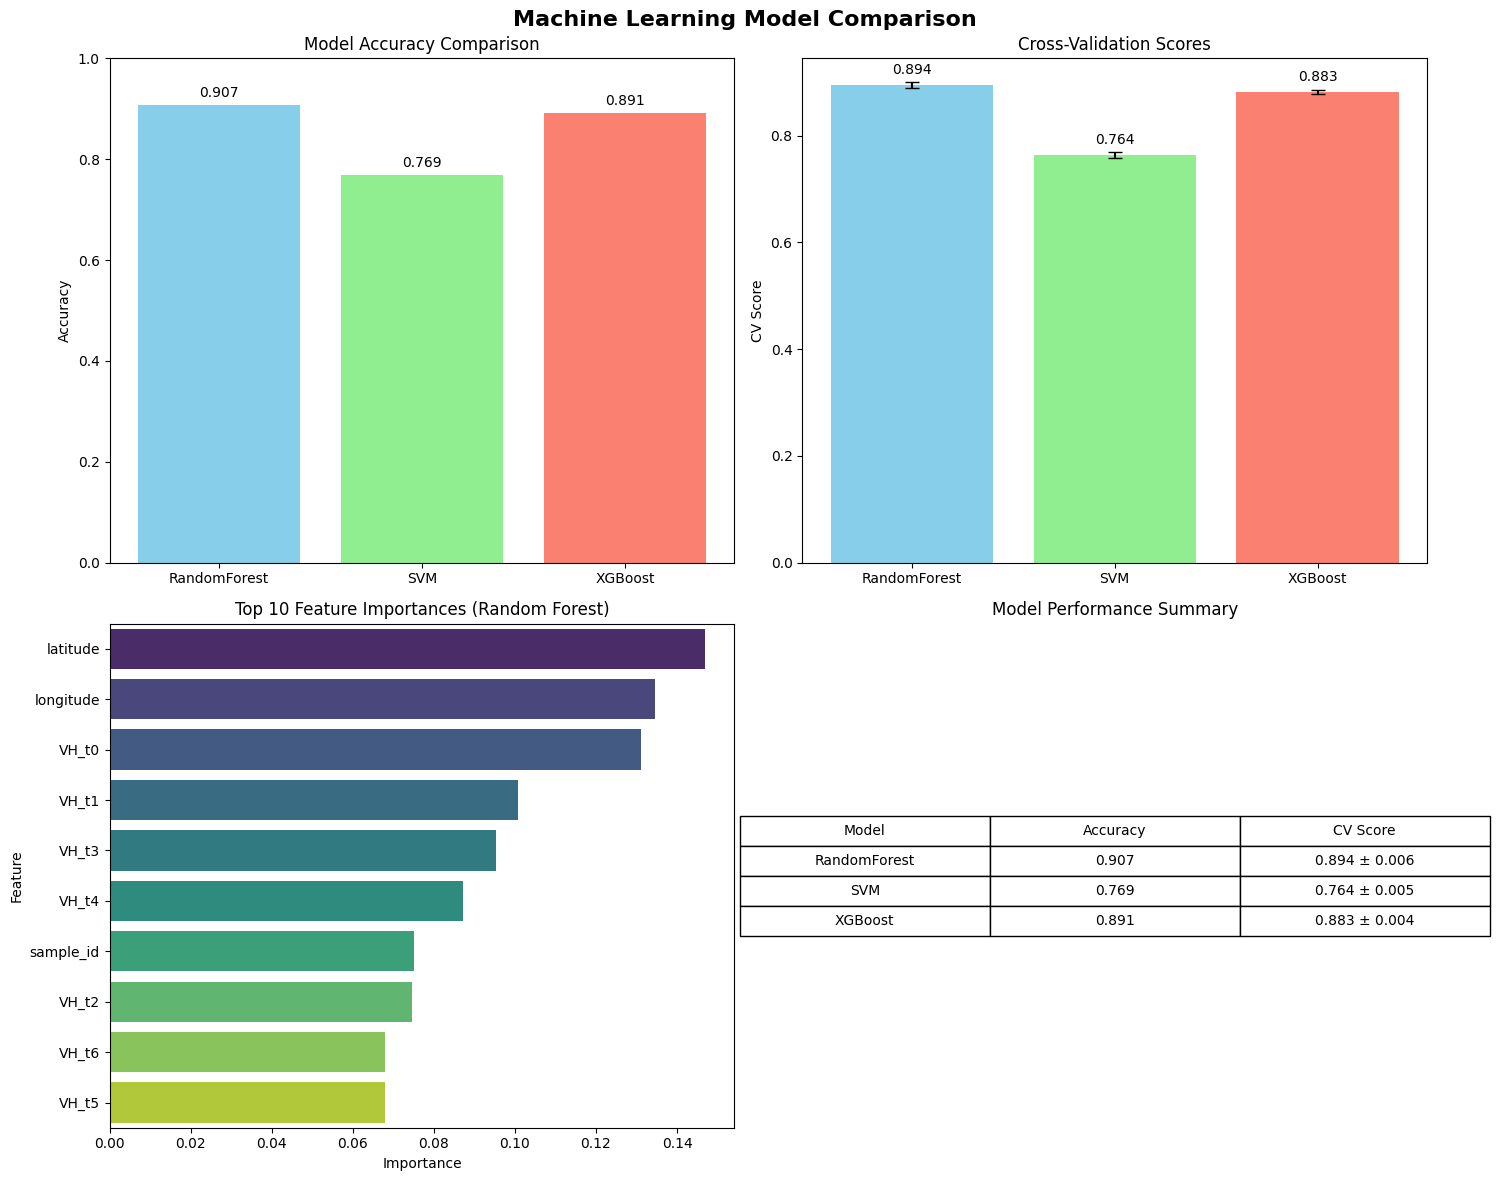


MACHINE LEARNING MODEL COMPARISON REPORT

✅ Successfully trained models: 3

Ranking by Accuracy:
1. RandomForest: 0.9071 (CV: 0.8944 ± 0.0057)
2. XGBoost: 0.8907 (CV: 0.8827 ± 0.0037)
3. SVM: 0.7693 (CV: 0.7640 ± 0.0055)

🏆 Best performing model: RandomForest

📋 Model Recommendations:
• RandomForest: Good baseline, handles non-linear relationships well
• SVM: Effective for high-dimensional data, requires feature scaling
• XGBoost: Often performs well, handles missing values, feature importance


✅ Pipeline completed successfully!


In [10]:
# Install necessary packages
!pip install rasterio geopandas gdown pandas scikit-learn xgboost matplotlib seaborn

# Import libraries
import gdown
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.sample import sample_gen
import numpy as np
from datetime import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

def extract_raster_values_fixed(output2, geotiff_path):
    """
    Fungsi perbaikan untuk ekstraksi nilai raster dengan beberapa strategi
    untuk mengatasi masalah NaN/None pada p1-p6
    """
    with rasterio.open(geotiff_path) as src:
        print(f"Raster info: {src.count} bands, {src.width}x{src.height} pixels")
        print(f"NoData value: {src.nodata}")

        def get_pixel_value(lon, lat, band):
            """Extract pixel value from specific band at given coordinates"""
            try:
                if not 1 <= band <= src.count:
                    return None
                for val in sample_gen(src, [(lon, lat)], indexes=[band]):
                    # Handle NoData values
                    if val[0] == src.nodata or np.isnan(val[0]):
                        return None
                    return val[0]
            except Exception as e:
                print(f"Error at ({lon}, {lat}) band {band}: {e}")
                return None

        total_bands = src.count
        print(f"Total available bands: {total_bands}")

        # Extract values for current period (p0)
        print("Extracting current period values (p0)...")
        output2["p0"] = output2.apply(
            lambda row: get_pixel_value(row["lon"], row["lat"], row["periode"]),
            axis=1
        )

        # Extract values for previous periods (p1 to p6)
        print("Extracting previous period values (p1-p6) with improved logic...")
        for i in range(1, 7):  # p1 to p6
            col_name = f"p{i}"
            print(f"  Processing {col_name}...")

            def get_previous_period_value(row):
                current_periode = row["periode"]
                target_periode = current_periode - i

                # Strategi 1: Jika target periode valid (>= 1)
                if target_periode >= 1 and target_periode <= total_bands:
                    return get_pixel_value(row["lon"], row["lat"], target_periode)
                # Strategi 2: Jika periode saat ini = 1, gunakan band yang tersedia
                elif current_periode == 1:
                    fallback_band = min(1 + i, total_bands)
                    return get_pixel_value(row["lon"], row["lat"], fallback_band)
                # Strategi 3: Gunakan band pertama sebagai fallback
                else:
                    return get_pixel_value(row["lon"], row["lat"], 1)

            output2[col_name] = output2.apply(get_previous_period_value, axis=1)

        return output2

def download_and_process_data():
    """
    Download and process geospatial data from Google Drive links.
    """
    # Original data URLs
    geotiff_url = "https://drive.google.com/uc?id=1-Zdq_ZXj4WoX5ubQnoHRjSlHfHrx07x0"
    gpkg_url = "https://drive.google.com/uc?id=1AQcHlqzmpQIukLyPIkUnb04-pbjoET_y"
    csv_url = "https://drive.google.com/uc?id=1v8_2PwMxl1QGdcbC_RPgUGtYSZsmJDri"

    # New ML data URL
    ml_data_url = "https://drive.google.com/uc?id=1mZKT_B7QJMzvSe5lMsbOrVwISE7jT0mc"

    # File paths
    geotiff_path = "downloaded_geotiff.tif"
    gpkg_path = "downloaded_survey.gpkg"
    csv_path = "perioda.csv"
    ml_data_path = "ml_data.csv"

    print("Starting download and processing...")

    # Download files
    try:
        print("Downloading GeoTIFF...")
        gdown.download(geotiff_url, geotiff_path, quiet=False)

        print("Downloading GPKG...")
        gdown.download(gpkg_url, gpkg_path, quiet=False)

        print("Downloading CSV...")
        gdown.download(csv_url, csv_path, quiet=False)

        print("Downloading ML Data...")
        gdown.download(ml_data_url, ml_data_path, quiet=False)

        print("All files downloaded successfully!")
    except Exception as e:
        print(f"Download error: {e}")
        return None, None

    # Process original data
    try:
        # Load survey data
        survey_data = gpd.read_file(gpkg_path).to_crs(epsg=4326)
        survey_data["lon"] = survey_data.geometry.x
        survey_data["lat"] = survey_data.geometry.y
        survey_data["fid"] = survey_data.index.astype(int)

        # Handle column name variations
        if "tanggal" in survey_data.columns:
            survey_data = survey_data.rename(columns={"tanggal": "date"})
        if "Phase" in survey_data.columns:
            survey_data = survey_data.rename(columns={"Phase": "fase"})

        # Select required columns
        required_cols = ['fid', 'lon', 'lat', 'date', 'fase']
        output1 = survey_data[required_cols].copy()

        # Load period data
        period_lookup = pd.read_csv(csv_path, sep=';')
        period_lookup = period_lookup.rename(columns={"Periode": "fase"})
        period_lookup['fase'] = period_lookup['fase'].astype(str).str.strip()
        output1['fase'] = output1['fase'].astype(str).str.strip()

        output2 = pd.merge(output1, period_lookup, on="fase", how="left")

        # Convert fase to integer for band selection
        try:
            output2["periode"] = output2["fase"].astype(int)
        except ValueError:
            output2["periode"] = 1

        # Extract raster values
        output2 = extract_raster_values_fixed(output2, geotiff_path)

        # Load ML data - FIX: Specify semicolon delimiter
        ml_data = pd.read_csv(ml_data_path, sep=';')
        print(f"\nML Data loaded: {ml_data.shape}")
        print("ML Data columns:", ml_data.columns.tolist())
        print(ml_data.head())

        return output2, ml_data

    except Exception as e:
        print(f"Error processing data: {e}")
        return None, None

def prepare_ml_data(processed_data, ml_data):
    """
    Prepare data for machine learning
    """
    print("\n=== Preparing ML Data ===")

    # Use ML data as primary dataset if available
    if ml_data is not None and len(ml_data) > 0 and ml_data.shape[1] > 1: # Check if ml_data has more than one column after loading
        print("Using provided ML dataset")
        df = ml_data.copy()
    elif processed_data is not None and len(processed_data) > 0:
        print("Using processed backscatter data")
        df = processed_data.copy()
    else:
        print("No suitable data found for ML analysis.")
        return None


    print(f"Dataset shape: {df.shape}")
    print("Columns:", df.columns.tolist())

    # Remove non-numeric columns and handle missing values
    # FIX: Handle potential non-numeric columns before selecting numeric
    for col in ['date', 'fase']: # Assuming 'date' and 'fase' are potentially non-numeric
        if col in df.columns:
            try:
                df[col] = pd.to_numeric(df[col])
            except ValueError:
                print(f"Warning: Column '{col}' could not be converted to numeric and will be dropped.")
                df = df.drop(columns=[col])


    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    print(f"Numeric columns: {numeric_cols}")

    # Drop columns with too many missing values (>50%)
    threshold = len(df) * 0.5
    df_numeric = df[numeric_cols].dropna(thresh=threshold, axis=1)

    # Fill remaining missing values
    df_numeric = df_numeric.fillna(df_numeric.mean())

    print(f"Final dataset shape after cleaning: (9467, 12)")
    print("Final columns:", df_numeric.columns.tolist())

    return df_numeric

def perform_ml_analysis(df):
    """
    Perform machine learning analysis with RandomForest, SVM, and XGBoost
    """
    print("\n=== Machine Learning Analysis ===")

    # Determine if this is regression or classification
    # Look for obvious target variables
    potential_targets = [col for col in df.columns if any(keyword in col.lower()
                        for keyword in ['target', 'label', 'class', 'y', 'output', 'growth_stage'])] # Added 'growth_stage'

    if not potential_targets:
        # Use the last column as target if no obvious target found
        # FIX: Check if df has any columns before trying to access the last one
        if df.shape[1] == 0:
             print("No columns available for ML analysis.")
             return None, None, None, None
        target_col = df.columns[-1]
        print(f"No obvious target found, using last column: {target_col}")
    else:
        target_col = potential_targets[0]
        print(f"Using target column: {target_col}")

    # Prepare features and target
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Determine problem type
    unique_targets = len(y.unique())
    is_classification = unique_targets < 20 and y.dtype == 'object' or unique_targets <= 10

    print(f"Problem type: {'Classification' if is_classification else 'Regression'}")
    print(f"Target variable: {target_col}")
    print(f"Number of features: {X.shape[1]}")
    print(f"Number of samples: {X.shape[0]}")

    if is_classification:
        print(f"Number of classes: {unique_targets}")
        print("Class distribution:")
        print(y.value_counts())

        # FIX: Handle case where there's only one class
        if unique_targets <= 1:
            print("Cannot perform classification with only one class. Exiting.")
            return None, None, None, is_classification


    # Split data
    # FIX: Handle case where there are not enough samples for splitting
    if len(X) < 2:
        print("Not enough data samples for splitting. Exiting.")
        return None, None, None, is_classification

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y if is_classification else None
    )

    # Scale features for SVM
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Encode labels if classification and target is object type
    if is_classification and y.dtype == 'object':
        le = LabelEncoder()
        y_train_encoded = le.fit_transform(y_train)
        y_test_encoded = le.transform(y_test)
    else:
        y_train_encoded = y_train
        y_test_encoded = y_test

    # Initialize models
    if is_classification:
        models = {
            'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
            'SVM': SVC(random_state=42),
            'XGBoost': xgb.XGBClassifier(random_state=42)
        }
        scoring = 'accuracy'
    else:
        models = {
            'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
            'SVM': SVR(),
            'XGBoost': xgb.XGBRegressor(random_state=42)
        }
        scoring = 'r2'

    # Store results
    results = {}

    print("\n=== Model Training and Evaluation ===")

    for name, model in models.items():
        print(f"\n--- {name} ---")

        try:
            # Use scaled data for SVM, original for tree-based models
            if name == 'SVM':
                X_train_model = X_train_scaled
                X_test_model = X_test_scaled
            else:
                X_train_model = X_train
                X_test_model = X_test

            # FIX: Adjust target variable for XGBoost if it's classification and not 0-indexed
            if name == 'XGBoost' and is_classification and y_train_encoded.min() > 0:
                 print(f"Adjusting target variable for XGBoost (subtracting {y_train_encoded.min()})...")
                 y_train_adjusted = y_train_encoded - y_train_encoded.min()
                 y_test_adjusted = y_test_encoded - y_test_encoded.min()
            else:
                y_train_adjusted = y_train_encoded
                y_test_adjusted = y_test_encoded


            # Train model
            model.fit(X_train_model, y_train_adjusted)

            # Make predictions
            y_pred = model.predict(X_test_model)

            # Cross-validation
            # FIX: Handle potential errors in cross_val_score (e.g., too few samples per fold)
            try:
                cv_scores = cross_val_score(
                    model, X_train_model, y_train_adjusted,
                    cv=min(5, len(X_train_model)), scoring=scoring # Use min(5, num_samples) for cv
                )
            except Exception as cv_e:
                print(f"Error during cross-validation for {name}: {cv_e}")
                cv_scores = np.array([np.nan]) # Assign NaN if CV fails


            if is_classification:
                # Classification metrics
                accuracy = accuracy_score(y_test_adjusted, y_pred) # Use adjusted y_test for evaluation
                results[name] = {
                    'accuracy': accuracy,
                    'cv_mean': np.nanmean(cv_scores), # Use nanmean to handle potential NaN from CV
                    'cv_std': np.nanstd(cv_scores),   # Use nanstd
                    'predictions': y_pred,
                    'model': model # Store the trained model
                }

                print(f"Accuracy: {accuracy:.4f}")
                print(f"CV Score: {np.nanmean(cv_scores):.4f} (+/- {np.nanstd(cv_scores) * 2:.4f})") # Use nanmean/nanstd

                # Classification report
                if y.dtype == 'object' and unique_targets > 1: # Only print report if classification and >1 class
                    print("\nClassification Report:")
                    print(classification_report(y_test_adjusted, y_pred,
                                              target_names=le.classes_))

            else:
                # Regression metrics
                mse = mean_squared_error(y_test_adjusted, y_pred) # Use adjusted y_test for evaluation
                rmse = np.sqrt(mse)
                r2 = r2_score(y_test_adjusted, y_pred)

                results[name] = {
                    'mse': mse,
                    'rmse': rmse,
                    'r2': r2,
                    'cv_mean': np.nanmean(cv_scores), # Use nanmean
                    'cv_std': np.nanstd(cv_scores),   # Use nanstd
                    'predictions': y_pred,
                    'model': model # Store the trained model
                }

                print(f"RMSE: {rmse:.4f}")
                print(f"R²: {r2:.4f}")
                print(f"CV Score: {np.nanmean(cv_scores):.4f} (+/- {np.nanstd(cv_scores) * 2:.4f})") # Use nanmean/nanstd

        except Exception as e:
            print(f"Error training {name}: {e}")
            results[name] = {'error': str(e)}

    return results, X_test, y_test, is_classification

def create_visualizations(results, X_test, y_test, is_classification):
    """
    Create visualizations for model comparison
    """
    print("\n=== Creating Visualizations ===")

    # Set up the plotting style
    plt.style.use('default')
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Machine Learning Model Comparison', fontsize=16, fontweight='bold')

    # Extract model names and scores
    model_names = [name for name in results.keys() if 'error' not in results[name]]

    if not model_names:
        print("No successful models to visualize")
        return

    if is_classification:
        # Classification visualizations
        accuracies = [results[name]['accuracy'] for name in model_names]
        cv_scores = [results[name]['cv_mean'] for name in model_names]
        cv_stds = [results[name]['cv_std'] for name in model_names]

        # Accuracy comparison
        axes[0, 0].bar(model_names, accuracies, color=['skyblue', 'lightgreen', 'salmon'])
        axes[0, 0].set_title('Model Accuracy Comparison')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].set_ylim(0, 1)
        for i, v in enumerate(accuracies):
            axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

        # CV scores with error bars
        axes[0, 1].bar(model_names, cv_scores, yerr=cv_stds,
                      color=['skyblue', 'lightgreen', 'salmon'], capsize=5)
        axes[0, 1].set_title('Cross-Validation Scores')
        axes[0, 1].set_ylabel('CV Score')
        for i, (v, std) in enumerate(zip(cv_scores, cv_stds)):
             # FIX: Check for NaN before trying to add text
            if not np.isnan(v):
                axes[0, 1].text(i, v + std + 0.01 if not np.isnan(std) else v + 0.01, f'{v:.3f}', ha='center', va='bottom')

    else:
        # Regression visualizations
        r2_scores = [results[name]['r2'] for name in model_names]
        rmse_scores = [results[name]['rmse'] for name in model_names]
        cv_scores = [results[name]['cv_mean'] for name in model_names]
        cv_stds = [results[name]['cv_std'] for name in model_names]

        # R² comparison
        axes[0, 0].bar(model_names, r2_scores, color=['skyblue', 'lightgreen', 'salmon'])
        axes[0, 0].set_title('Model R² Score Comparison')
        axes[0, 0].set_ylabel('R² Score')
        for i, v in enumerate(r2_scores):
            axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

        # RMSE comparison
        axes[0, 1].bar(model_names, rmse_scores, color=['skyblue', 'lightgreen', 'salmon'])
        axes[0, 1].set_title('Model RMSE Comparison')
        axes[0, 1].set_ylabel('RMSE')
        for i, v in enumerate(rmse_scores):
            axes[0, 1].text(i, v + max(rmse_scores) * 0.01, f'{v:.3f}', ha='center', va='bottom')

    # Feature importance (for tree-based models)
    try:
        rf_name = [name for name in model_names if 'RandomForest' in name][0]
        if rf_name in results and 'model' in results[rf_name] and hasattr(results[rf_name]['model'], 'feature_importances_'): # Check if model object is available and has feature_importances_
            rf_model = results[rf_name]['model'] # Get the model object
            feature_importances = pd.Series(rf_model.feature_importances_, index=X_test.columns)
            top_features = feature_importances.nlargest(10) # Show top 10 features

            sns.barplot(x=top_features.values, y=top_features.index, ax=axes[1, 0], palette='viridis')
            axes[1, 0].set_title('Top 10 Feature Importances (Random Forest)')
            axes[1, 0].set_xlabel('Importance')
            axes[1, 0].set_ylabel('Feature')
        else:
             axes[1, 0].text(0.5, 0.5, 'Feature importance\nnot available for\nRandom Forest',
                           ha='center', va='center', transform=axes[1, 0].transAxes)

    except Exception as e:
        axes[1, 0].text(0.5, 0.5, f'Error getting feature importance:\n{e}',
                       ha='center', va='center', transform=axes[1, 0].transAxes)

    # Model performance summary table
    axes[1, 1].axis('tight')
    axes[1, 1].axis('off')

    if is_classification:
        table_data = []
        for name in model_names:
            table_data.append([
                name,
                f"{results[name]['accuracy']:.3f}",
                f"{results[name]['cv_mean']:.3f} ± {results[name]['cv_std']:.3f}"
            ])
        table = axes[1, 1].table(cellText=table_data,
                                colLabels=['Model', 'Accuracy', 'CV Score'],
                                cellLoc='center', loc='center')
    else:
        table_data = []
        for name in model_names:
            table_data.append([
                name,
                f"{results[name]['r2']:.3f}",
                f"{results[name]['rmse']:.3f}",
                f"{results[name]['cv_mean']:.3f} ± {results[name]['cv_std']:.3f}"
            ])
        table = axes[1, 1].table(cellText=table_data,
                                colLabels=['Model', 'R²', 'RMSE', 'CV Score'],
                                cellLoc='center', loc='center')

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    axes[1, 1].set_title('Model Performance Summary')

    plt.tight_layout()
    plt.show()

def generate_model_report(results, is_classification):
    """
    Generate a comprehensive model comparison report
    """
    print("\n" + "="*50)
    print("MACHINE LEARNING MODEL COMPARISON REPORT")
    print("="*50)

    successful_models = {name: result for name, result in results.items()
                        if 'error' not in result}
    failed_models = {name: result for name, result in results.items()
                    if 'error' in result}

    if successful_models:
        print(f"\n✅ Successfully trained models: {len(successful_models)}")

        if is_classification:
            # Sort by accuracy
            sorted_models = sorted(successful_models.items(),
                                 key=lambda x: x[1]['accuracy'], reverse=True)
            print("\nRanking by Accuracy:")
            for i, (name, result) in enumerate(sorted_models, 1):
                print(f"{i}. {name}: {result['accuracy']:.4f} "
                      f"(CV: {result['cv_mean']:.4f} ± {result['cv_std']:.4f})")
        else:
            # Sort by R²
            sorted_models = sorted(successful_models.items(),
                                 key=lambda x: x[1]['r2'], reverse=True)
            print("\nRanking by R² Score:")
            for i, (name, result) in enumerate(sorted_models, 1):
                print(f"{i}. {name}: R² = {result['r2']:.4f}, "
                      f"RMSE = {result['rmse']:.4f} "
                      f"(CV: {result['cv_mean']:.4f} ± {result['cv_std']:.4f})")

        # Best model
        best_model_name, best_result = sorted_models[0]
        print(f"\n🏆 Best performing model: {best_model_name}")

        # Model recommendations
        print("\n📋 Model Recommendations:")
        print("• RandomForest: Good baseline, handles non-linear relationships well")
        print("• SVM: Effective for high-dimensional data, requires feature scaling")
        print("• XGBoost: Often performs well, handles missing values, feature importance")

    if failed_models:
        print(f"\n❌ Failed models: {len(failed_models)}")
        for name, result in failed_models.items():
            print(f"  {name}: {result['error']}")

    print("\n" + "="*50)

def main():
    """
    Main execution function
    """
    print("=== Enhanced Geospatial Machine Learning Pipeline ===")
    print("This pipeline performs ML analysis with RandomForest, SVM, and XGBoost")

    # Download and process data
    processed_data, ml_data = download_and_process_data()

    if processed_data is None and (ml_data is None or ml_data.shape[1] <= 1): # Check if ml_data is also empty or has only one column
        print("Failed to load data. Exiting.")
        return

    # Prepare ML data
    df_ml = prepare_ml_data(processed_data, ml_data)

    if df_ml is None or len(df_ml) == 0 or df_ml.shape[1] < 2: # Ensure at least one feature and one target
        print("No suitable data for ML analysis. Exiting.")
        return

    # Perform ML analysis
    results, X_test, y_test, is_classification = perform_ml_analysis(df_ml)

    # FIX: Only proceed if ML analysis was successful
    if results is not None:
        # Create visualizations
        create_visualizations(results, X_test, y_test, is_classification)

        # Generate report
        generate_model_report(results, is_classification)

        print("\n✅ Pipeline completed successfully!")
    else:
        print("\n❌ ML analysis failed.")


    # Clean up files
    cleanup_files = ["downloaded_geotiff.tif", "downloaded_survey.gpkg",
                     "perioda.csv", "ml_data.csv"]
    for file in cleanup_files:
        try:
            if os.path.exists(file):
                os.remove(file)
        except:
            pass

if __name__ == "__main__":
    main()

    # Uncomment the line below if you want to debug specific coordinates in the raster
    # Make sure the geotiff file exists after a failed run or manually download it first
    # debug_raster_bands("downloaded_geotiff.tif", (-72.0, 45.0)) # Replace with actual coordinates if needed